In [ ]:
@author: Brian Jackon 
@email: Bleejack@gmail.com
@title: Rhythm DS Take-Home

In [1]:
import numpy as np
import pandas as pd
import calendar
from datetime import datetime as dt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Import mlflow
import mlflow
import mlflow.sklearn

# Import sci-kit survival functions/tools
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.preprocessing import OneHotEncoder
from sksurv.metrics import concordance_index_censored
from sksurv.ensemble import RandomSurvivalForest

# import hyperopt
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

/Users/brjax/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


Absent data, I have simulated data to the specifications provided. The “MarkovChain” class in the cell below outputs a 
time series tuple $(s_{t},p_{t})$. The three contract states lead to a 3x3 transition matrix where $P_{i,j}$ corresponds 
to the probability of transitioning from $i$ to $j$. I refer to the entry in row $i$ and column $j$ of matrix $M$ as 
$m_{i,j}$ and $m_{i,*}$ to refer to the entire row $i$ of $M$. Using 1-based indexing, $m_{3,*}=[0,0,1]$ as Churn is an 
absorbing state. <br>
$m_{2,*}=[0,m_{2,2},m_{2,3}]$ as the "Contract” state is not reachable from any other state. The process
to fill the unknown entries of $m_{1,*}$ and $m_{2,*}$ goes as follows. 

Two matrices, $A_{10X3}$ and $B_{10X2}$, are generated with each row of each matrix sampled from a Dirichlet distribution 
such that the entries of every row sum to 1. The parameter $\alpha$, which governs the concentration of probability mass, 
is randomly chosen from the range $[0.5,3)$ for each row of $A$ and $B$. Each row of the respective matrices corresponds 
to one of the 10 energy plans offered. Hence each plan will have upper triangle transition matrix where the correlation 
of the plan to the churn event is governed by the probability mass distribution of transitions from state 1(Contract) and 
2(Variable). A plan(or “Product_id”) is randomly selected as an integer in the range $[0,9]$ and then used as the index 
to select the corresponding rows of $A,B$. The row from $A$ is used to fill $m_{1,*}$ and the row from $B$ is used to 
fill entries $m_{2,2},m_{2,3}$ ensuring a stochastic matrix. 

The generator outputs a series of states that ensue from the starting “Contract” state. The starting periods varies to 
be within 12 months of January 2017 allowing for varying duration across simulated customers. There is no reason I chose 
this period. There is no consideration of seasonality in this simulation. I have initialized the class to run for 36 
steps(months), though this parameter can be changed. 

In [2]:
def add_months(base_date, n_months):
    """
    helper function to facilitate varying time series by adding a integer(chosen randomly) to a base month.
    :param base_date: benchmark month
    :param n_months: months to be added to the base_date
    :return: month t + N where base month is t. add_months(Feb 2017,13) returns March 2018. 
    """
    month = base_date.month - 1 + n_months
    year = base_date.year + month // 12
    month = month % 12 + 1
    day = min(base_date.day, calendar.monthrange(year, month)[1])
    return dt(year, month, day)


class MarkovChain(object):
    def __init__(self, transition_matrix, x1, x2, states, base_mo, mo_range, dur_range):
        """
        
        :param transition_matrix: stochastic matrix specifying transition probabilities between states
        :param x1: MX3 Matrix with dirichlet sampled entries where M corresponds to the number of plans available
        :param x2: MX2 Matrix with dirichlet sampled entries where M corresponds to the number of plans available
        :param states: the state space
        :param base_mo: an arbitrarily chosen base month used to create variable starting months 
        :param mo_range: the range to which the initial contract month can succeed the base_mo 
        :param dur_range: how many steps/transitions to similate
        """
        self.transition_matrix = np.atleast_2d(transition_matrix)
        self.x1 = x1
        self.x2 = x2
        self.states = states
        self.index_dict = {self.states[index]: index for index in
                           range(len(self.states))}
        self.state_dict = {index: self.states[index] for index in
                           range(len(self.states))}
        self.product_id = np.random.randint(0, len(x1), size=1)[0]
        self.start_mo = add_months(base_mo, np.random.randint(0, mo_range, size=1)[0])
        self.dur_range = dur_range
        self.trans_mat = self.set_matrix()

    def set_matrix(self):
        """

        :return: 3x3 matrix where the entire first row and the last two entries of the second are set 
        to values corresponding to the simulated transition matrix for the chosen energy plan. 
        """
        trans_mat_cp = self.transition_matrix.copy()
        trans_mat_cp[0, :] = np.sort(self.x1[self.product_id])[::-1]
        trans_mat_cp[1, 1:] = np.sort(self.x2[self.product_id])[::-1]
        return trans_mat_cp

    def next_state(self, current_state):
        """
        
        :param current_state: the current state in the customers simulated path.
        :return: next state in the path as stochastically chosen per the transition matrix
        """
        state_index = self.index_dict[current_state]
        return np.random.choice(self.states,
                                p=self.trans_mat[state_index, :])

    def generate_states(self, current_state):
        """
        
        :param current_state: 
        :return: A chain of subsequent states per the methods dictating transitions
        """

        n = self.dur_range
        future_states = [current_state]
        for i in range(n):
            next_state = self.next_state(current_state)
            future_states.append(next_state)
            current_state = next_state
        prod = np.full(len(future_states), self.product_id)
        last_dt = add_months(self.start_mo, len(future_states))
        dt_col = pd.date_range(self.start_mo, last_dt,
                               freq='MS').strftime("%Y-%b").tolist()[:len(future_states)]
        # print(len(prod), len(dt_col), len(future_states))
        df_tmp = pd.DataFrame({'date': dt_col, 'state': future_states, 'product': prod})
        df_tmp['state_plan'] = list(zip(df_tmp.state, df_tmp['product']))
        df_tmp = df_tmp.drop(['state', 'product'], axis=1)
        return df_tmp

In [3]:
transition_matrix = [[0.4, 0.3, 0.3],
                     [0.0, 0.5, 0.5],
                     [0.0, 0.0, 1.0]]
states = ['Contract', 'Variable', 'Churn']

x1 = np.array([np.random.dirichlet(np.ones(3) * x, size=1) for x in np.random.uniform(low=0.5, high=3, size=(10,))])
x1 = np.squeeze(x1)
x2 = np.array([np.random.dirichlet(np.ones(2) * x, size=1) for x in np.random.uniform(low=0.5, high=3, size=(10,))])
x2 = np.squeeze(x2)
# Base month chosen arbitrarily 
base_mo = dt(2017, 1, 1)
#initialize markov chain to verify output
re_customer = MarkovChain(transition_matrix=transition_matrix, x1=x1, x2=x2,
                          states=states, base_mo=base_mo, mo_range=12, dur_range=36)
print(re_customer.generate_states(current_state='Contract'))


        date     state_plan
0   2017-Jun  (Contract, 3)
1   2017-Jul  (Contract, 3)
2   2017-Aug  (Contract, 3)
3   2017-Sep  (Variable, 3)
4   2017-Oct  (Variable, 3)
5   2017-Nov  (Variable, 3)
6   2017-Dec  (Variable, 3)
7   2018-Jan  (Variable, 3)
8   2018-Feb     (Churn, 3)
9   2018-Mar     (Churn, 3)
10  2018-Apr     (Churn, 3)
11  2018-May     (Churn, 3)
12  2018-Jun     (Churn, 3)
13  2018-Jul     (Churn, 3)
14  2018-Aug     (Churn, 3)
15  2018-Sep     (Churn, 3)
16  2018-Oct     (Churn, 3)
17  2018-Nov     (Churn, 3)
18  2018-Dec     (Churn, 3)
19  2019-Jan     (Churn, 3)
20  2019-Feb     (Churn, 3)
21  2019-Mar     (Churn, 3)
22  2019-Apr     (Churn, 3)
23  2019-May     (Churn, 3)
24  2019-Jun     (Churn, 3)
25  2019-Jul     (Churn, 3)
26  2019-Aug     (Churn, 3)
27  2019-Sep     (Churn, 3)
28  2019-Oct     (Churn, 3)
29  2019-Nov     (Churn, 3)
30  2019-Dec     (Churn, 3)
31  2020-Jan     (Churn, 3)
32  2020-Feb     (Churn, 3)
33  2020-Mar     (Churn, 3)
34  2020-Apr     (Ch

The MarkovChain class simulates a singles customer in the format the data is expected to be ingested per the project spec. 
The function below builds the dataframe I will use for modeling. The function simulates n customers (10,000 is this 
exercise) and creates a row for each of them. The columns are defined below:<br>
1. id: unique customer id <br>
2. Con_dur: Duration in the Contract State <br>
3. Var_dur: Duration in the Variable State <br>
4. Prod_id: Plan chosen <br>
5. Duration: Time since signup if customer hasn't churned or time between signup and the churn event.
6. Churn/Event: Binary indicator {Churn: 1, Active: 0}  

Given the state transitions are acyclic, features for state persistence are used to emulate a multi-state model.  



In [4]:
def build_df(n):
    """
    Builds dataframe with predictive features. Durations in states s1 and s2 are used to mimic a multi-state
    model. 
    :param n: 
    :return: 
    """
    for i in range(n):
        customer = MarkovChain(transition_matrix=transition_matrix, x1=x1, x2=x2,
                          states=states, base_mo=base_mo, mo_range=12, dur_range=36)
        df1 = customer.generate_states(current_state='Contract')
        df2 = pd.DataFrame(df1['state_plan'].tolist(), index=df1.index, columns=['State','Product'])
        assert len(np.unique(df2['Product']))==1, "More than 1 product type"
        prod_id = np.unique(df2['Product'])[0]
        ind_churn = np.argwhere(df2['State']=='Churn').ravel()
        ind_var = np.argwhere(df2['State']=='Variable').ravel()
        ind_con = np.argwhere(df2['State']=='Contract').ravel()
        if len(ind_churn) and len(ind_var):
            churn = 1
            duration = ind_churn.min()
            var_dur = ind_churn.min()-ind_var.min()
            con_dur = ind_var.min()
        elif len(ind_churn) and not len(ind_var):
            churn = 1
            duration = con_dur = ind_churn.min()
            var_dur = 0
        elif not len(ind_churn) and len(ind_var):
            churn = 0
            duration = ind_var.max()
            var_dur = ind_var.max()-ind_var.min()
            con_dur = ind_var.min()
        else:
            churn = var_dur = 0
            duration = con_dur = ind_con.max()
        dataframe_dict.append({'id':i,'Con_dur':con_dur, 'Var_dur':var_dur, 'Prod_id': prod_id, 'Duration':duration,
                   'Churn': churn})
    cols = ['id','Con_dur','Var_dur','Prod_id', 'Duration','Churn']
    df_fin = pd.DataFrame(dataframe_dict, columns= cols)
    return df_fin
        

In [5]:
dataframe_dict = []
sim_df = build_df(10000)

/Users/brjax/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


In [6]:
sim_df.describe() 

id       Con_dur       Var_dur       Prod_id      Duration  \
count  10000.00000  10000.000000  10000.000000  10000.000000  10000.000000   
mean    4999.50000      2.992400      4.351100      4.591100      7.343500   
std     2886.89568      3.168019      8.076308      2.876444      8.880551   
min        0.00000      1.000000      0.000000      0.000000      1.000000   
25%     2499.75000      1.000000      0.000000      2.000000      2.000000   
50%     4999.50000      2.000000      1.000000      5.000000      4.000000   
75%     7499.25000      4.000000      4.000000      7.000000      8.000000   
max     9999.00000     36.000000     35.000000      9.000000     36.000000   

              Churn  
count  10000.000000  
mean       0.939700  
std        0.238054  
min        0.000000  
25%        1.000000  
50%        1.000000  
75%        1.000000  
max        1.000000

From the instruction to output the probability of churn in subsequent months, I assume a survival type model is desired 
to estimate the risk of attrition in each period vs a binary or multi-class problem where the probability of churning at
monthly intervals (say the next 2 months) is modeled.  



In [7]:
# Scikit Survival requires numbers as floats and the event indicator as a boolean.
sim_df = sim_df.astype('float')
sim_df['Event'] = sim_df['Churn'].astype('bool')
# The “Prod_id” column, which refers to the energy plan, is converted to a string here as it will later 
# be one-hot-encoded to avoid an ordinal interpretation by the model.  
sim_df['Prod_id'] = sim_df['Prod_id'].replace([0.,1.,2.,3.,4.,5.,6.,7.,8.,9.],
                                              ['p1','p2','p3','p4','p5','p6','p7','p8','p9','p10'])
sim_df.head()


id  Con_dur  Var_dur Prod_id  Duration  Churn  Event
0  0.0      2.0      0.0      p1       2.0    1.0   True
1  1.0      1.0      3.0      p1       4.0    1.0   True
2  2.0      3.0     32.0      p8      35.0    1.0   True
3  3.0      3.0      2.0      p1       5.0    1.0   True
4  4.0      5.0      4.0      p7       9.0    1.0   True

Generate Kaplan-Meier estimated survival functions to gauge differences between plans. 

In [8]:
for value in sim_df["Prod_id"].unique():
    mask = sim_df["Prod_id"] == value
    time_prod, survival_prob_prod = kaplan_meier_estimator(sim_df["Event"][mask],
                                                           sim_df["Duration"][mask])
    plt.step(time_prod, survival_prob_prod, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

<>:8: DeprecationWarning: invalid escape sequence \h
<>:8: DeprecationWarning: invalid escape sequence \h
<>:8: DeprecationWarning: invalid escape sequence \h
<ipython-input-8-3404dab7fc75>:8: DeprecationWarning: invalid escape sequence \h
  plt.ylabel("est. probability of survival $\hat{S}(t)$")


In [9]:
# Specify features
features = np.setdiff1d(sim_df.columns, ['Duration','Churn','Event','id']).tolist()

#Create train/test indices
idx_train, idx_test = train_test_split(range(sim_df.shape[0]), test_size = 0.3)
train_df = sim_df.loc[idx_train].reset_index( drop = True )
test_df  = sim_df.loc[idx_test].reset_index( drop = True )

# Create the X,y data
X_train, X_test = train_df[features], test_df[features]
y_train, y_test = train_df[['Event','Duration']], test_df[['Event','Duration']]

In [10]:
# Prod_id needs to be one-hot-encoded. OneHotEconder requires the categorical column to be of categorical type.

X_tr = X_train.copy()
X_tr['Prod_id'] = X_tr['Prod_id'].astype('category')
X_train_num= OneHotEncoder().fit_transform(X_tr)
y_train_num = y_train.to_records(index=False)

X_tst = X_test.copy()
X_tst['Prod_id'] = X_tst['Prod_id'].astype('category')
X_test_num = OneHotEncoder().fit_transform(X_tst)
y_test_num = y_test.to_records(index=False)

In [11]:
X_test_num.dtypes

Con_dur        float64
Prod_id=p10    float64
Prod_id=p2     float64
Prod_id=p3     float64
Prod_id=p4     float64
Prod_id=p5     float64
Prod_id=p6     float64
Prod_id=p7     float64
Prod_id=p8     float64
Prod_id=p9     float64
Var_dur        float64
dtype: object

In [12]:
X_train_num.head()

Con_dur  Prod_id=p10  Prod_id=p2  Prod_id=p3  Prod_id=p4  Prod_id=p5  \
0      2.0          0.0         0.0         0.0         0.0         0.0   
1      8.0          0.0         0.0         0.0         0.0         0.0   
2      3.0          0.0         0.0         0.0         0.0         1.0   
3      7.0          0.0         0.0         0.0         1.0         0.0   
4      1.0          0.0         1.0         0.0         0.0         0.0   

   Prod_id=p6  Prod_id=p7  Prod_id=p8  Prod_id=p9  Var_dur  
0         0.0         0.0         0.0         0.0      1.0  
1         0.0         1.0         0.0         0.0      7.0  
2         0.0         0.0         0.0         0.0      3.0  
3         0.0         0.0         0.0         0.0      0.0  
4         0.0         0.0         0.0         0.0      3.0

I use a Random Survival Forest for this exercise. The approach is non-parametric and like other random forest models it 
inherently handles interaction effects, whereas using a Cox Proportional Hazard model requires additional residuals 
testing regarding the proportional hazards assumption, controlling for outliers and detecting non-linearities in the relationship 
between the log hazard and covariates. CPH is referenced as an alternative(as opposed to other choices) given its 
popularity. The choice is choice more practical for the time constraints of the exercise and I chose not to simulate 
data to accommodate a particular model.  

I assume a review of Random Survival Forests is outside the scope of this exercise, but at a high level it grows survival 
trees from bootstrapped samples. At each tree node the split across a randomly selected subset of candidate variables is 
chosen to maximize the survival difference between child nodes. I will leave the review of splitting methods and model 
hyperparameters to the reader.  

The model is implemented with “scikit-survival.” Absent time to build a model from scratch I chose a framework relatively 
environment agnostic. Should this notebook be executed by the reviewer, the package is easy to setup and familiarity with 
scikit-learn is ubiquitous. For related reasons I chose Random Survival Forests over other ensemble tree methods such as 
Conditional Inference Survival Forest. 

The code block below implements Bayesian hyperparameter optimization using Hyperopt. The minimization objective is
(1-concordance_index) evaluated on the test set. 

In [17]:
MAX_EVALS = 100

def score(params):
    print ("Training with params : ")
    print (params)
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_samples_split'] = int(params['min_samples_split'])
    params['min_samples_leaf'] = int(params['min_samples_leaf'])
    model = RandomSurvivalForest(**params)
    model.fit(X_train_num, y_train_num)
    C_index = model.score(X_test_num, y_test_num)
    loss = 1 - C_index    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}


def optimize(trials):

    space = {
             'n_estimators' : hp.quniform('n_estimators', 500, 600, 1),
             'max_depth' : hp.quniform('max_depth', 3, 6, 1),
             'min_samples_split' : hp.quniform('min_samples_split', 6, 20, 1),
             'min_samples_leaf' : hp.quniform('min_samples_leaf', 3, 20, 1),
             'max_features' : "sqrt",
             'n_jobs' : -1,
             }
    

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=MAX_EVALS)

    print (best)

trials = Trials()

optimize(trials)

Training with params : 
{'max_depth': 5.0, 'max_features': 'sqrt', 'min_samples_leaf': 4.0, 'min_samples_split': 20.0, 'n_estimators': 591.0, 'n_jobs': -1}
Training with params : 
{'max_depth': 3.0, 'max_features': 'sqrt', 'min_samples_leaf': 9.0, 'min_samples_split': 18.0, 'n_estimators': 565.0, 'n_jobs': -1}
Training with params : 
{'max_depth': 4.0, 'max_features': 'sqrt', 'min_samples_leaf': 10.0, 'min_samples_split': 16.0, 'n_estimators': 575.0, 'n_jobs': -1}
Training with params : 
{'max_depth': 5.0, 'max_features': 'sqrt', 'min_samples_leaf': 16.0, 'min_samples_split': 8.0, 'n_estimators': 585.0, 'n_jobs': -1}
Training with params : 
{'max_depth': 5.0, 'max_features': 'sqrt', 'min_samples_leaf': 13.0, 'min_samples_split': 9.0, 'n_estimators': 582.0, 'n_jobs': -1}
Training with params : 
{'max_depth': 5.0, 'max_features': 'sqrt', 'min_samples_leaf': 4.0, 'min_samples_split': 9.0, 'n_estimators': 506.0, 'n_jobs': -1}
Training with params : 
{'max_depth': 5.0, 'max_features': 'sqrt

The code block below trains the model based on the optimized hyper-parameters above. The model and associated hyperparameters
are logged with MLflow to track experiments and model iterations which can be evluated through a GUI. MLflow models objects 
can be deployed using a REST API. 

In [18]:
##### Survival trees
random_state = 2718

params = {'max_depth': 3.0, 'min_samples_leaf': 15.0, 'min_samples_split': 13.0, 'n_estimators': 567.0}
params['n_estimators'] = int(params['n_estimators'])
params['max_depth'] = int(params['max_depth'])
params['min_samples_split'] = int(params['min_samples_split'])
params['min_samples_leaf'] = int(params['min_samples_leaf'])
params['max_features'] = "sqrt"
params['n_jobs'] = -1
params['random_state'] = random_state

random_state = 2718
rsf = RandomSurvivalForest(**params)
rsf.fit(X_train_num, y_train_num)

train_c_i = rsf.score(X_train_num, y_train_num)
test_c_i = rsf.score(X_test_num, y_test_num)
print(f"C-Index: Train {train_c_i}, Test {test_c_i}")


mlflow.log_param("n_estimators", params['n_estimators'])
mlflow.log_param("max_depth", params['max_depth'])
mlflow.log_param("min_samples_split", params['min_samples_split'])
mlflow.log_param("min_samples_leaf", params['min_samples_leaf'])
mlflow.log_param("max_features", params['max_features'])
mlflow.log_param("n_jobs", params['n_jobs'])
mlflow.log_metric("C-index Train", train_c_i)
mlflow.log_metric("C-index Test", test_c_i)

## Uncomment to log and save model--directory must be specified,
# mlflow.sklearn.log_model(rsf, "RSFmodel")
# modelpath = "/rhythmDS/models/...")
# mlflow.sklearn.save_model(rsf, modelpath)


C-Index: Train 0.7740988009939338, Test 0.7816386584816023


The model is evaluated using the concordance index, which is a generalization of area under the ROC curve; models 
scoring above .5 are better than chance.  The C-index for training and testing sets are shown above.  

The models predict method outputs an ensemble risk score, which is the total number of churn events as estimated by the 
sum of the estimated ensemble cumulative hazard function. To get a quick gauge of how well the model ranks risk, I 
concatenate records from the test set owing to the lowest 5 durations and the top 5 durations. As observed, the risk
ranking is considerably higher for the lowest 5.  



In [19]:
dur_tmp = test_df['Duration'].argsort()
top_5_risk = X_test_num.iloc[dur_tmp[:5]]
bottom_5_risk = X_test_num.iloc[dur_tmp[-5:]]
test_risk_rank = pd.concat([top_5_risk,bottom_5_risk])
pd.Series(rsf.predict(test_risk_rank))

0    118.413478
1    118.161795
2    118.161795
3    120.247011
4    111.730805
5     16.288738
6     23.013917
7     23.013917
8     15.865083
9     16.670221
dtype: float64

 
Below I show the predicted survival function for the same concatenated dataset of top/bottom 5 in terms of duration. 
The “predict_survival_function” provides the survival probability in subsequent months as requested in the 
project spec. 

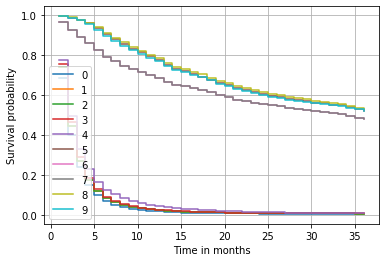

In [20]:
survival_t = rsf.predict_survival_function(test_risk_rank)

for i, s in enumerate(survival_t):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in months")
plt.grid(True)
plt.legend(loc="best")


I have refrained from additional specifications regarding DevOps and accomodating assumptions around the data 
infrastructure end ETL/ELT pipelines. The MLflow object is fairly portable and the “build_df” provides an instance of 
ingesting the data format specified.  

